# Agentic AI - Chart Generation

The **reflection pattern** an agentic workflow that generates data visualizations. A multi-modal LLM will review the first draft chart, identify potential improvements—such as chart type, labels, or color choices—and then rewrite the chart generation code to produce a more effective visualization.

1. **Generate an initial version (V1):**
Use a Large Language Model (LLM) to create the first version of the plotting code.

2. **Execute code and create chart:** 
Run the generated code and display the resulting chart. ** (check everywhere)

3. **Reflect on the output:**
Evaluate both the code and the chart using an LLM to detect areas for improvement (e.g., clarity, accuracy, design).

4. **Generate and execute improved version (V2):**
Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.


## 2. Setup: Initialize environment and client

In this step, you import the key libraries that will support the workflow:  

- **`re`**: Python’s regular expression module, which you’ll use to extract snippets of code or structured text from the LLM’s output.  
- **`json`**: Provides functions to read and write JSON, useful for handling structured responses returned by the LLM.  
- **`utils`**: A custom helper module. It includes utility functions to work with the dataset, generate charts, and display results in a clean, readable format.  


In [1]:
# Standard library imports
import re
import json
import utils

### 2.1. Loading the dataset

Coffee sales data.

In [2]:
# Use this utils.py function to load the data into a dataframe
df = utils.load_and_prepare_data('coffee_sales.csv')

# Grab a random sample to display
utils.print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-08-26,10:27,card,ANON-0000-0000-0408,2.302,Americano,3,8,2024
2024-08-26,08:11,card,ANON-0000-0000-0408,2.302,Americano,3,8,2024
2025-02-20,09:49,card,ANON-0000-0000-1198,2.596,Americano,1,2,2025
2025-03-20,15:50,card,ANON-0000-0000-1310,3.576,Cocoa,1,3,2025
2024-08-26,14:54,card,ANON-0000-0000-0003,2.302,Americano,3,8,2024


## 3. Building the pipeline

### 3.1 Step 1 — Generate Code to Create a Chart (V1)

In this step, prompt an LLM to write Python code that generates a chart in response to a user query about the coffee dataset. The dataset includes fields such as `date`, `coffee_type`, `quantity`, and `revenue`, pass this schema into the LLM so it knows what data is available.  

Prompt:  
**“Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.”**

The LLM’s output will be Python code using the **matplotlib** library.


In [3]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = utils.get_response(model, prompt)
    return response

In [4]:
# Generate initial code
code_v1 = generate_chart_code(
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model="gpt-4o-mini", 
    out_path_v1="chart_v1.png"
)

utils.print_html(code_v1, title="LLM output with first draft code")

### 3.2. Step 2 — Execute Code and Create Chart

Use a regular expression to extract the Python code that the LLM generated in the previous step (the part written between `<execute_python>` tags).  


1. **Extract the code:**  
   A regex pattern is used to grab the code that’s wrapped inside the `<execute_python>` tags.

2. **Execute the code:**
   The extracted code is run in a predefined global context where the DataFrame `df` is already available. This means code can directly use df without needing to reload the dataset.

3. **Generate the chart::**
   If the code executes successfully, it will create a chart and save it as `chart_v1.png`.

4. **View the chart in the notebook:**
   The saved chart is then displayed inline using `utils.print_html`, making it easy to review the results.


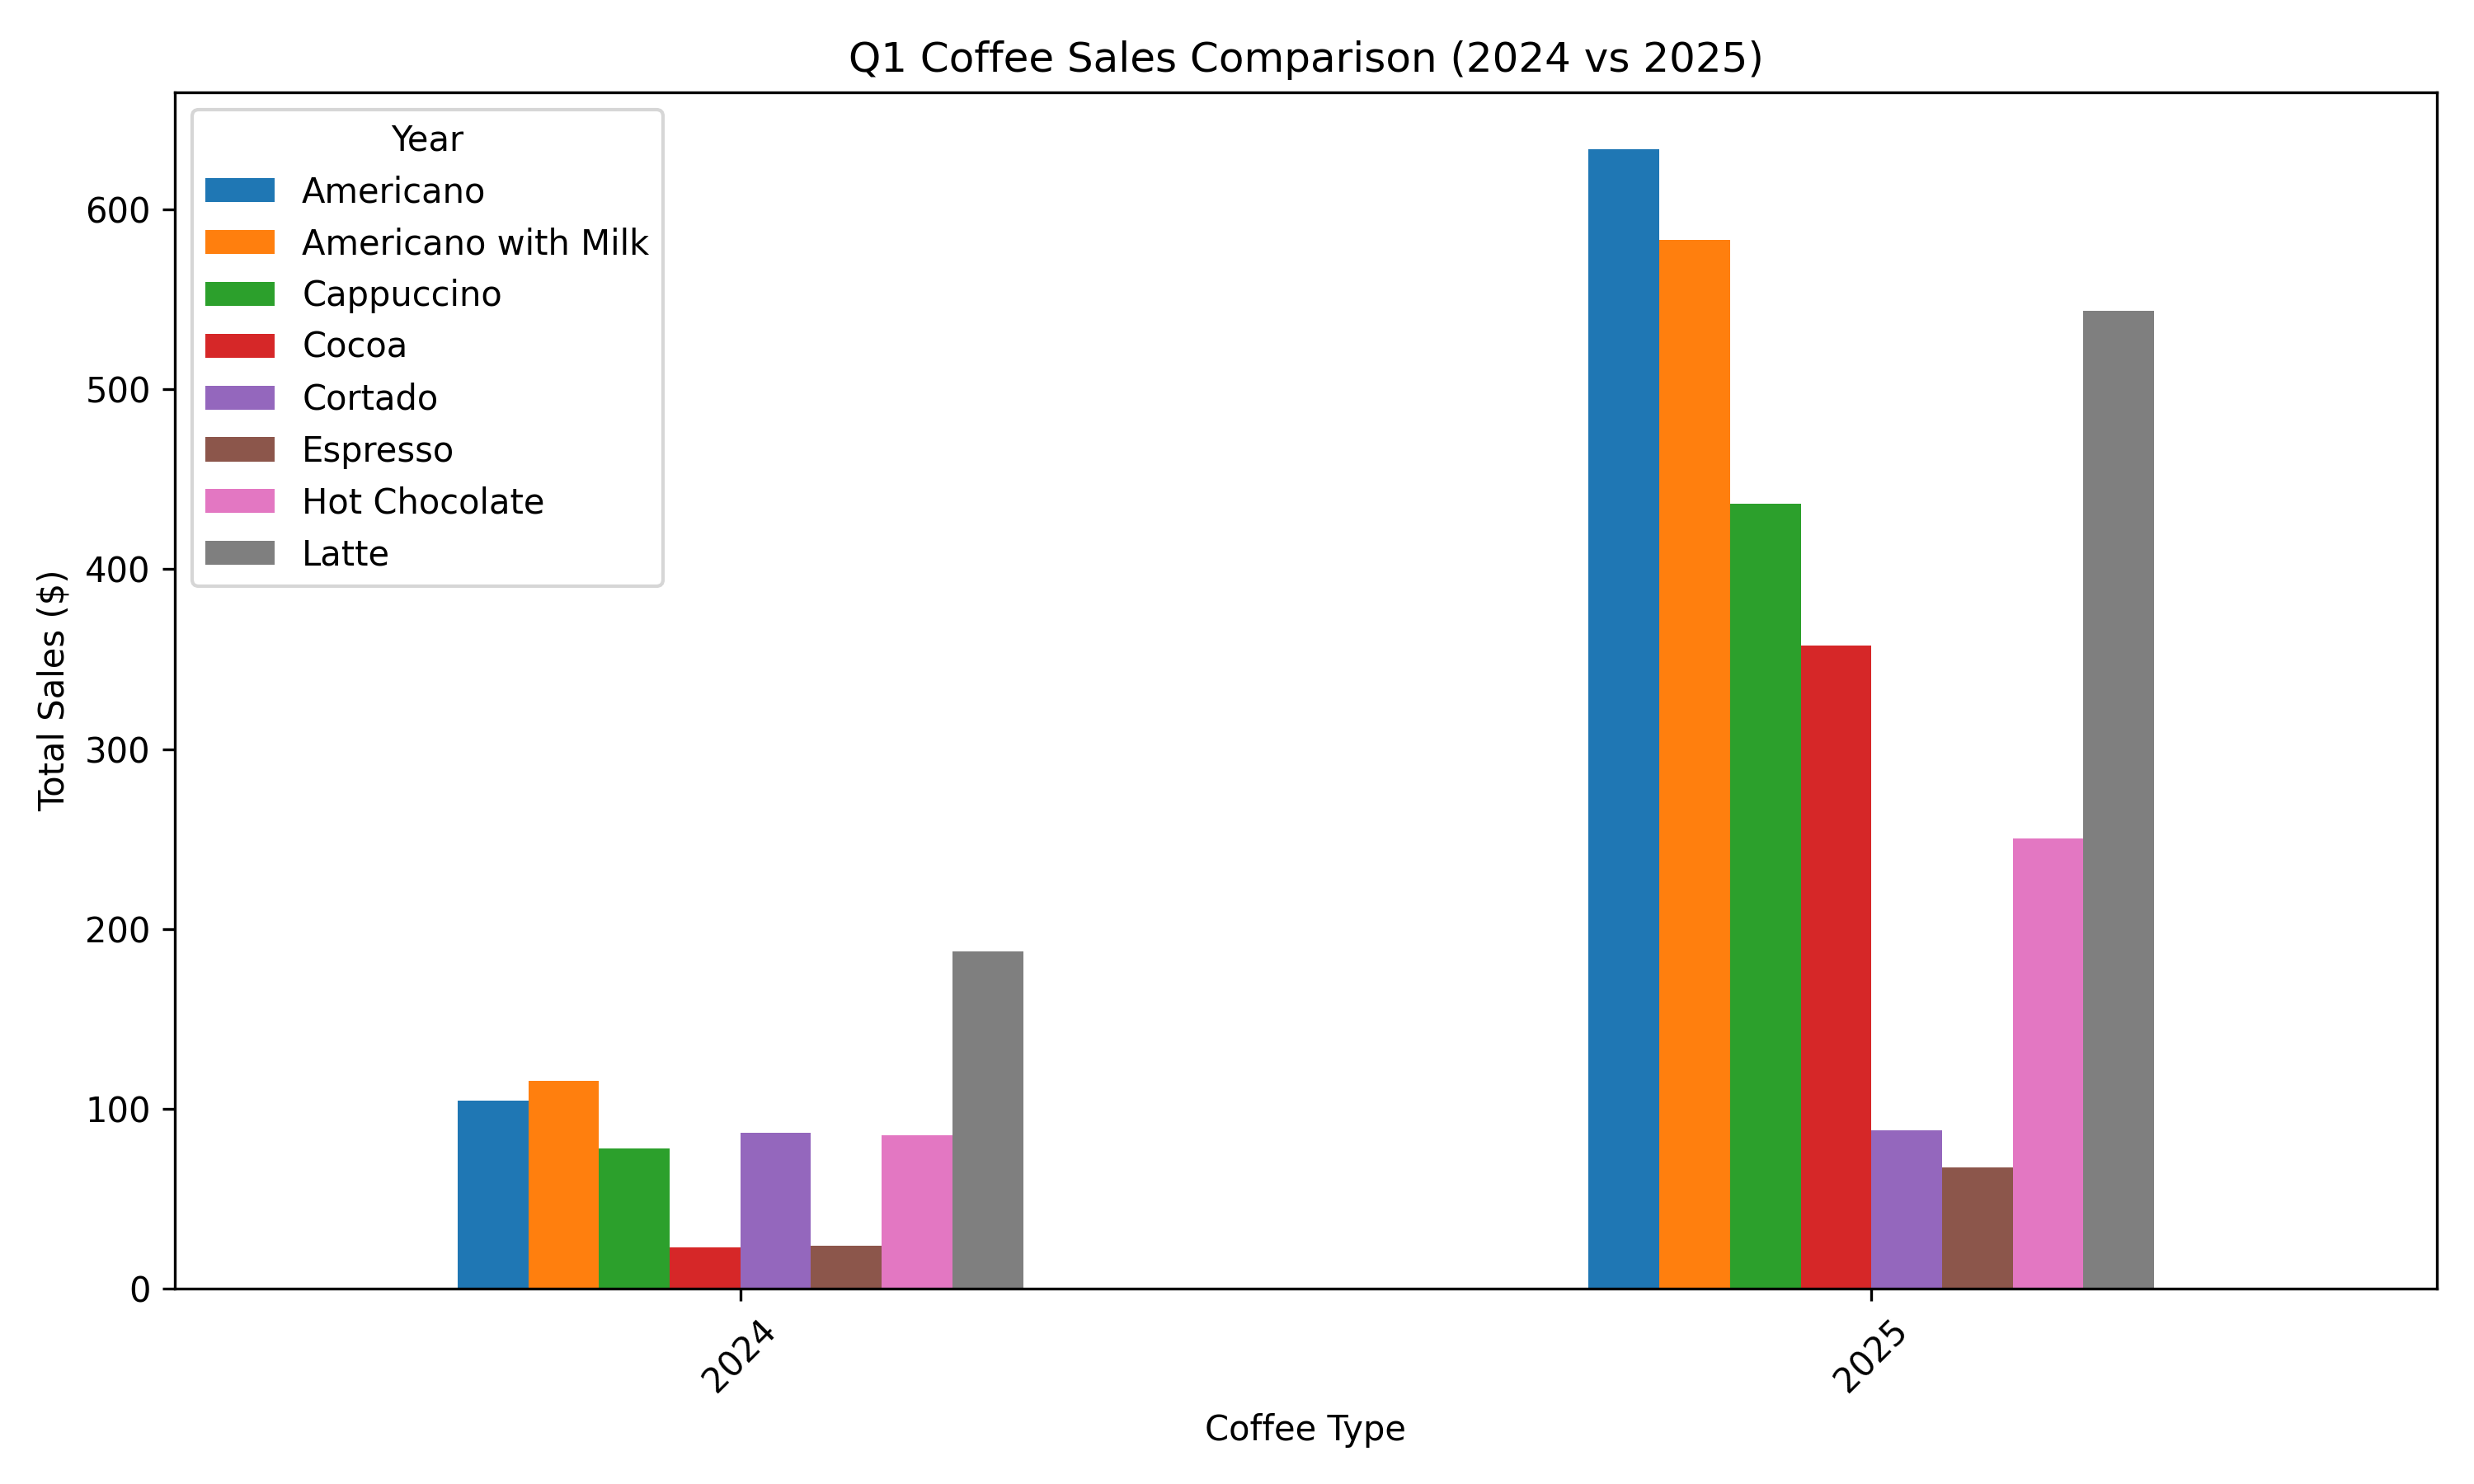

In [5]:
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    utils.print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# If code run successfully, the file chart_v1.png should have been generated
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

### 3.3. Step 3 — Reflect on the output

The goal here is to simulate how a human would review a first draft of a chart—looking for strengths, weaknesses, and areas for improvement.

Here’s what happens:

**1. Provide the chart to the LLM:**
The generated chart (chart_v1.png) is shared with the LLM so it can “see” the visualization.

**2. Analyze the chart visually:**
The LLM reviews elements like clarity, labeling, accuracy, and overall readability.

**3. Generate feedback:**
The LLM suggests improvements—for example, fixing axis labels, adjusting the chart type, improving color choices, or highlighting missing legends.

By doing this, create an intelligent feedback loop where the chart is not just produced once, but actively critiqued—setting the stage for a stronger second version (V2).

In [6]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,  
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction, 
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    media_type, b64 = utils.encode_image_b64(chart_path)
    

    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT!):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in df):
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    Instruction:
    {instruction}
    """


    # In case the name is "Claude" or "Anthropic", use the safe helper
    lower = model_name.lower()
    if "claude" in lower or "anthropic" in lower:
        # ✅ Use the safe helper that joins all text blocks and adds a system prompt
        content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    else:
        content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code

### 3.4 Step 4 — Generate and Execute Improved Version (V2)

In this final step, it’s time to generate and run the improved version of the chart (V2).  
After running the cell, **both the reflection written by the LLM** (explaining what needed improvement) **and the new code it generated**. The new code will be executed to produce the updated chart.  

In [7]:
# Generate feedback alongside reflected code
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",            
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model_name="o4-mini",
    out_path_v2="chart_v2.png",
    code_v1=code_v1,   # pass in the original code for context        
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")


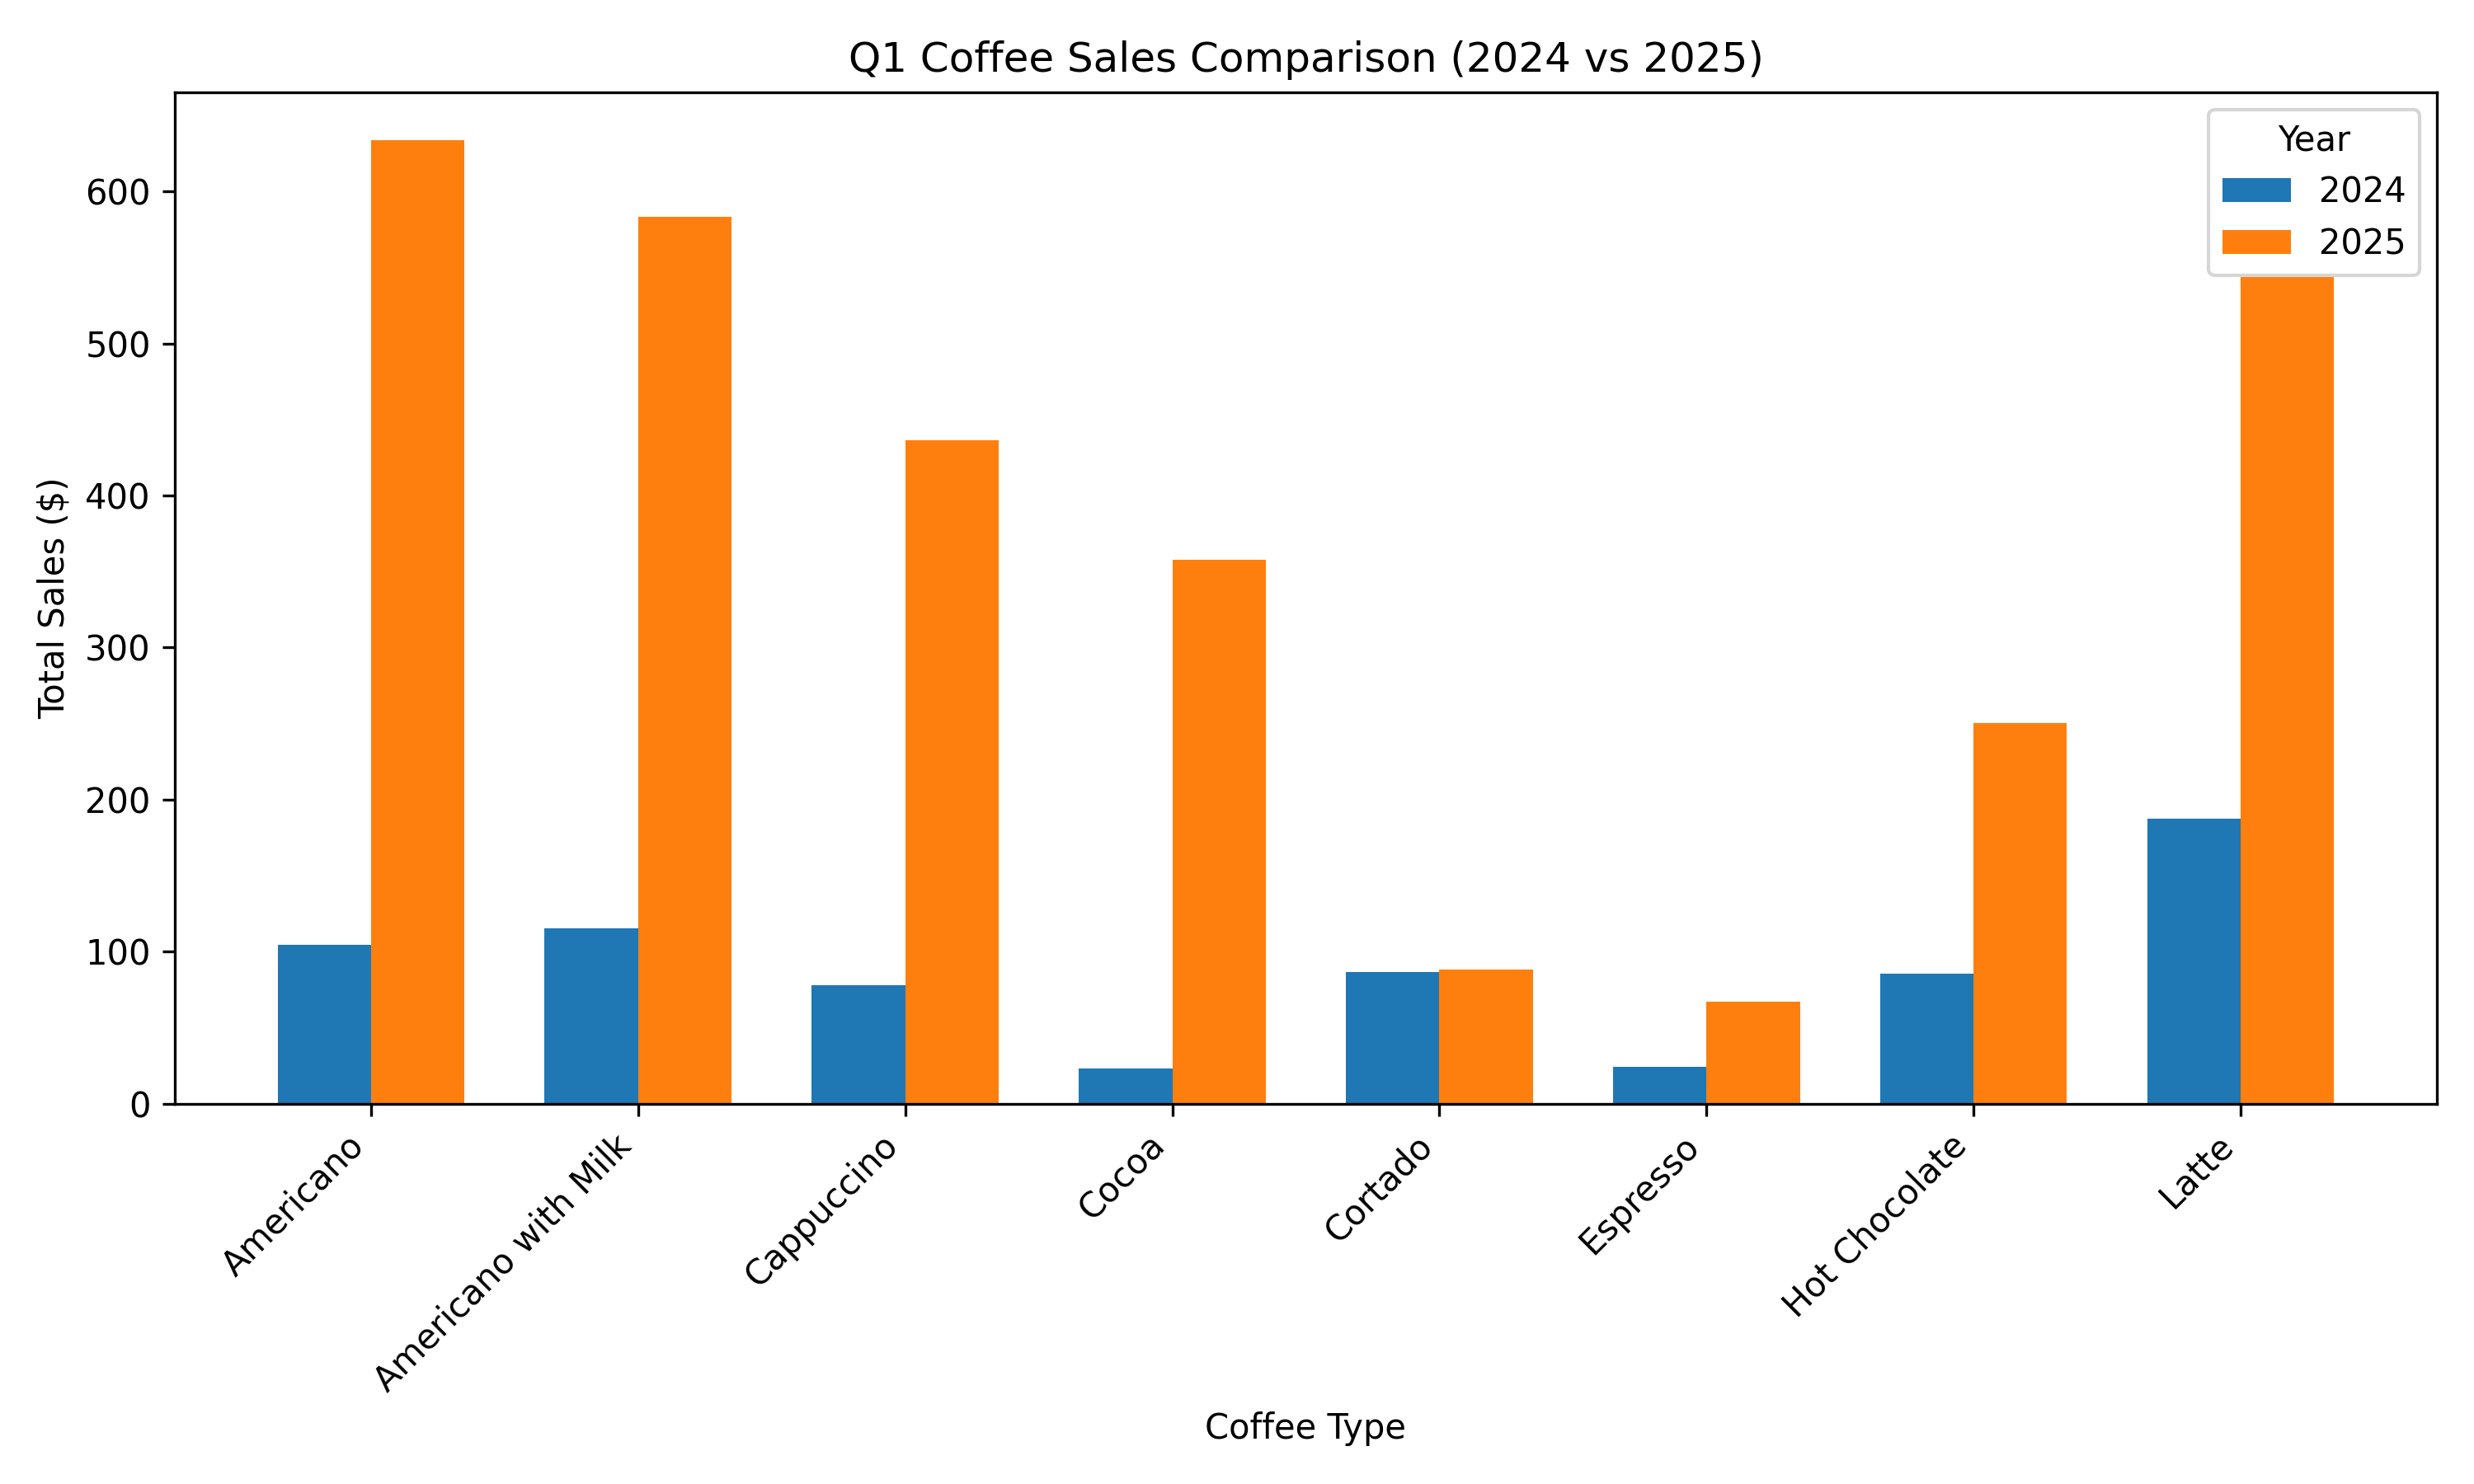

In [8]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

### 4. Put it all together — creating the end-to-end workflow

The `run_workflow` function links together the components you implemented earlier:

1) **Load and prepare data** — via `utils.load_and_prepare_data(...)`.  
2) **Generate V1 code** — with `generate_chart_code(...)`, which returns the first-draft matplotlib code (wrapped in `<execute_python>` tags).  
3) **Execute V1 immediately** — the workflow extracts the code between `<execute_python>` tags and runs it to produce the first chart image.  
4) **Reflect and refine** — `reflect_on_image_and_regenerate(...)` critiques the V1 image (and the original code) against the instruction, returns concise **feedback** plus **revised code (V2)**.  
5) **Execute V2 immediately** — the refined code is extracted and executed to generate the improved chart.

### What this workflow accepts
- **`dataset_path`**: location of the input CSV.  
- **`user_instructions`**: the chart request (e.g., “Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.”).  
- **`generation_model`**: model used for the initial code generation.  
- **`reflection_model`**: model used for the image-based reflection and code refinement.  
- **`image_basename`**: base filename for saving chart images (e.g., `chart_v1.png`, `chart_v2.png`).  

> Note: The chart execution steps are intentionally **hard-coded** to run right after code generation/refinement. This mirrors the workflow in the lecture and ensures you see each draft’s output before moving on.


In [9]:
def run_workflow(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    reflection_model: str,   
    image_basename: str = "chart",
    run_number: str = "001"
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """
    # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_{run_number}_v1.png"
    out_v2 = f"{image_basename}_{run_number}_v2.png"

    # 1) Generate code (V1)
    utils.print_html("Step 1: Generating chart code (V1)… 📈")
    code_v1 = generate_chart_code(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(initial_code, exec_globals)
    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html("Step 3: Reflecting on V1 (image + code) and generating improvements… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(reflected_code, exec_globals)
    utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }


In [10]:
from PIL import Image

def combine_charts_side_by_side(img_path1, img_path2, output_path="combined_chart.jpg", background_color=(255, 255, 255)):
    """
    Combines two chart images side by side into a single JPG file.

    Args:
        img_path1 (str): Path to the first PNG chart (e.g., 2024 chart).
        img_path2 (str): Path to the second PNG chart (e.g., 2025 chart).
        output_path (str): Path for the output JPG file.
        background_color (tuple): RGB tuple for background color. Default is white.

    Returns:
        str: Path to the combined JPG image.
    """
    # Open the two images
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)

    # Match heights if they differ
    if img1.height != img2.height:
        new_height = min(img1.height, img2.height)
        img1 = img1.resize((int(img1.width * new_height / img1.height), new_height))
        img2 = img2.resize((int(img2.width * new_height / img2.height), new_height))

    # Calculate combined width and create new image
    total_width = img1.width + img2.width
    combined_img = Image.new("RGB", (total_width, img1.height), color=background_color)

    # Paste both charts side by side
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (img1.width, 0))

    # Save the combined image as JPG
    combined_img.save(output_path, "JPEG", quality=95)

    return output_path

### Use simple prompt to create plot

date,time,cash_type,card,price,coffee_name,quarter,month,year
2025-02-09,17:24,card,ANON-0000-0000-1161,2.596,Cortado,1,2,2025
2024-05-26,10:27,card,ANON-0000-0000-0218,3.772,Hot Chocolate,2,5,2024
2024-10-09,10:06,card,ANON-0000-0000-0733,2.106,Espresso,4,10,2024
2024-08-13,16:09,card,ANON-0000-0000-0499,3.282,Cocoa,3,8,2024
2025-01-16,14:14,card,ANON-0000-0000-1097,3.576,Cappuccino,1,1,2025



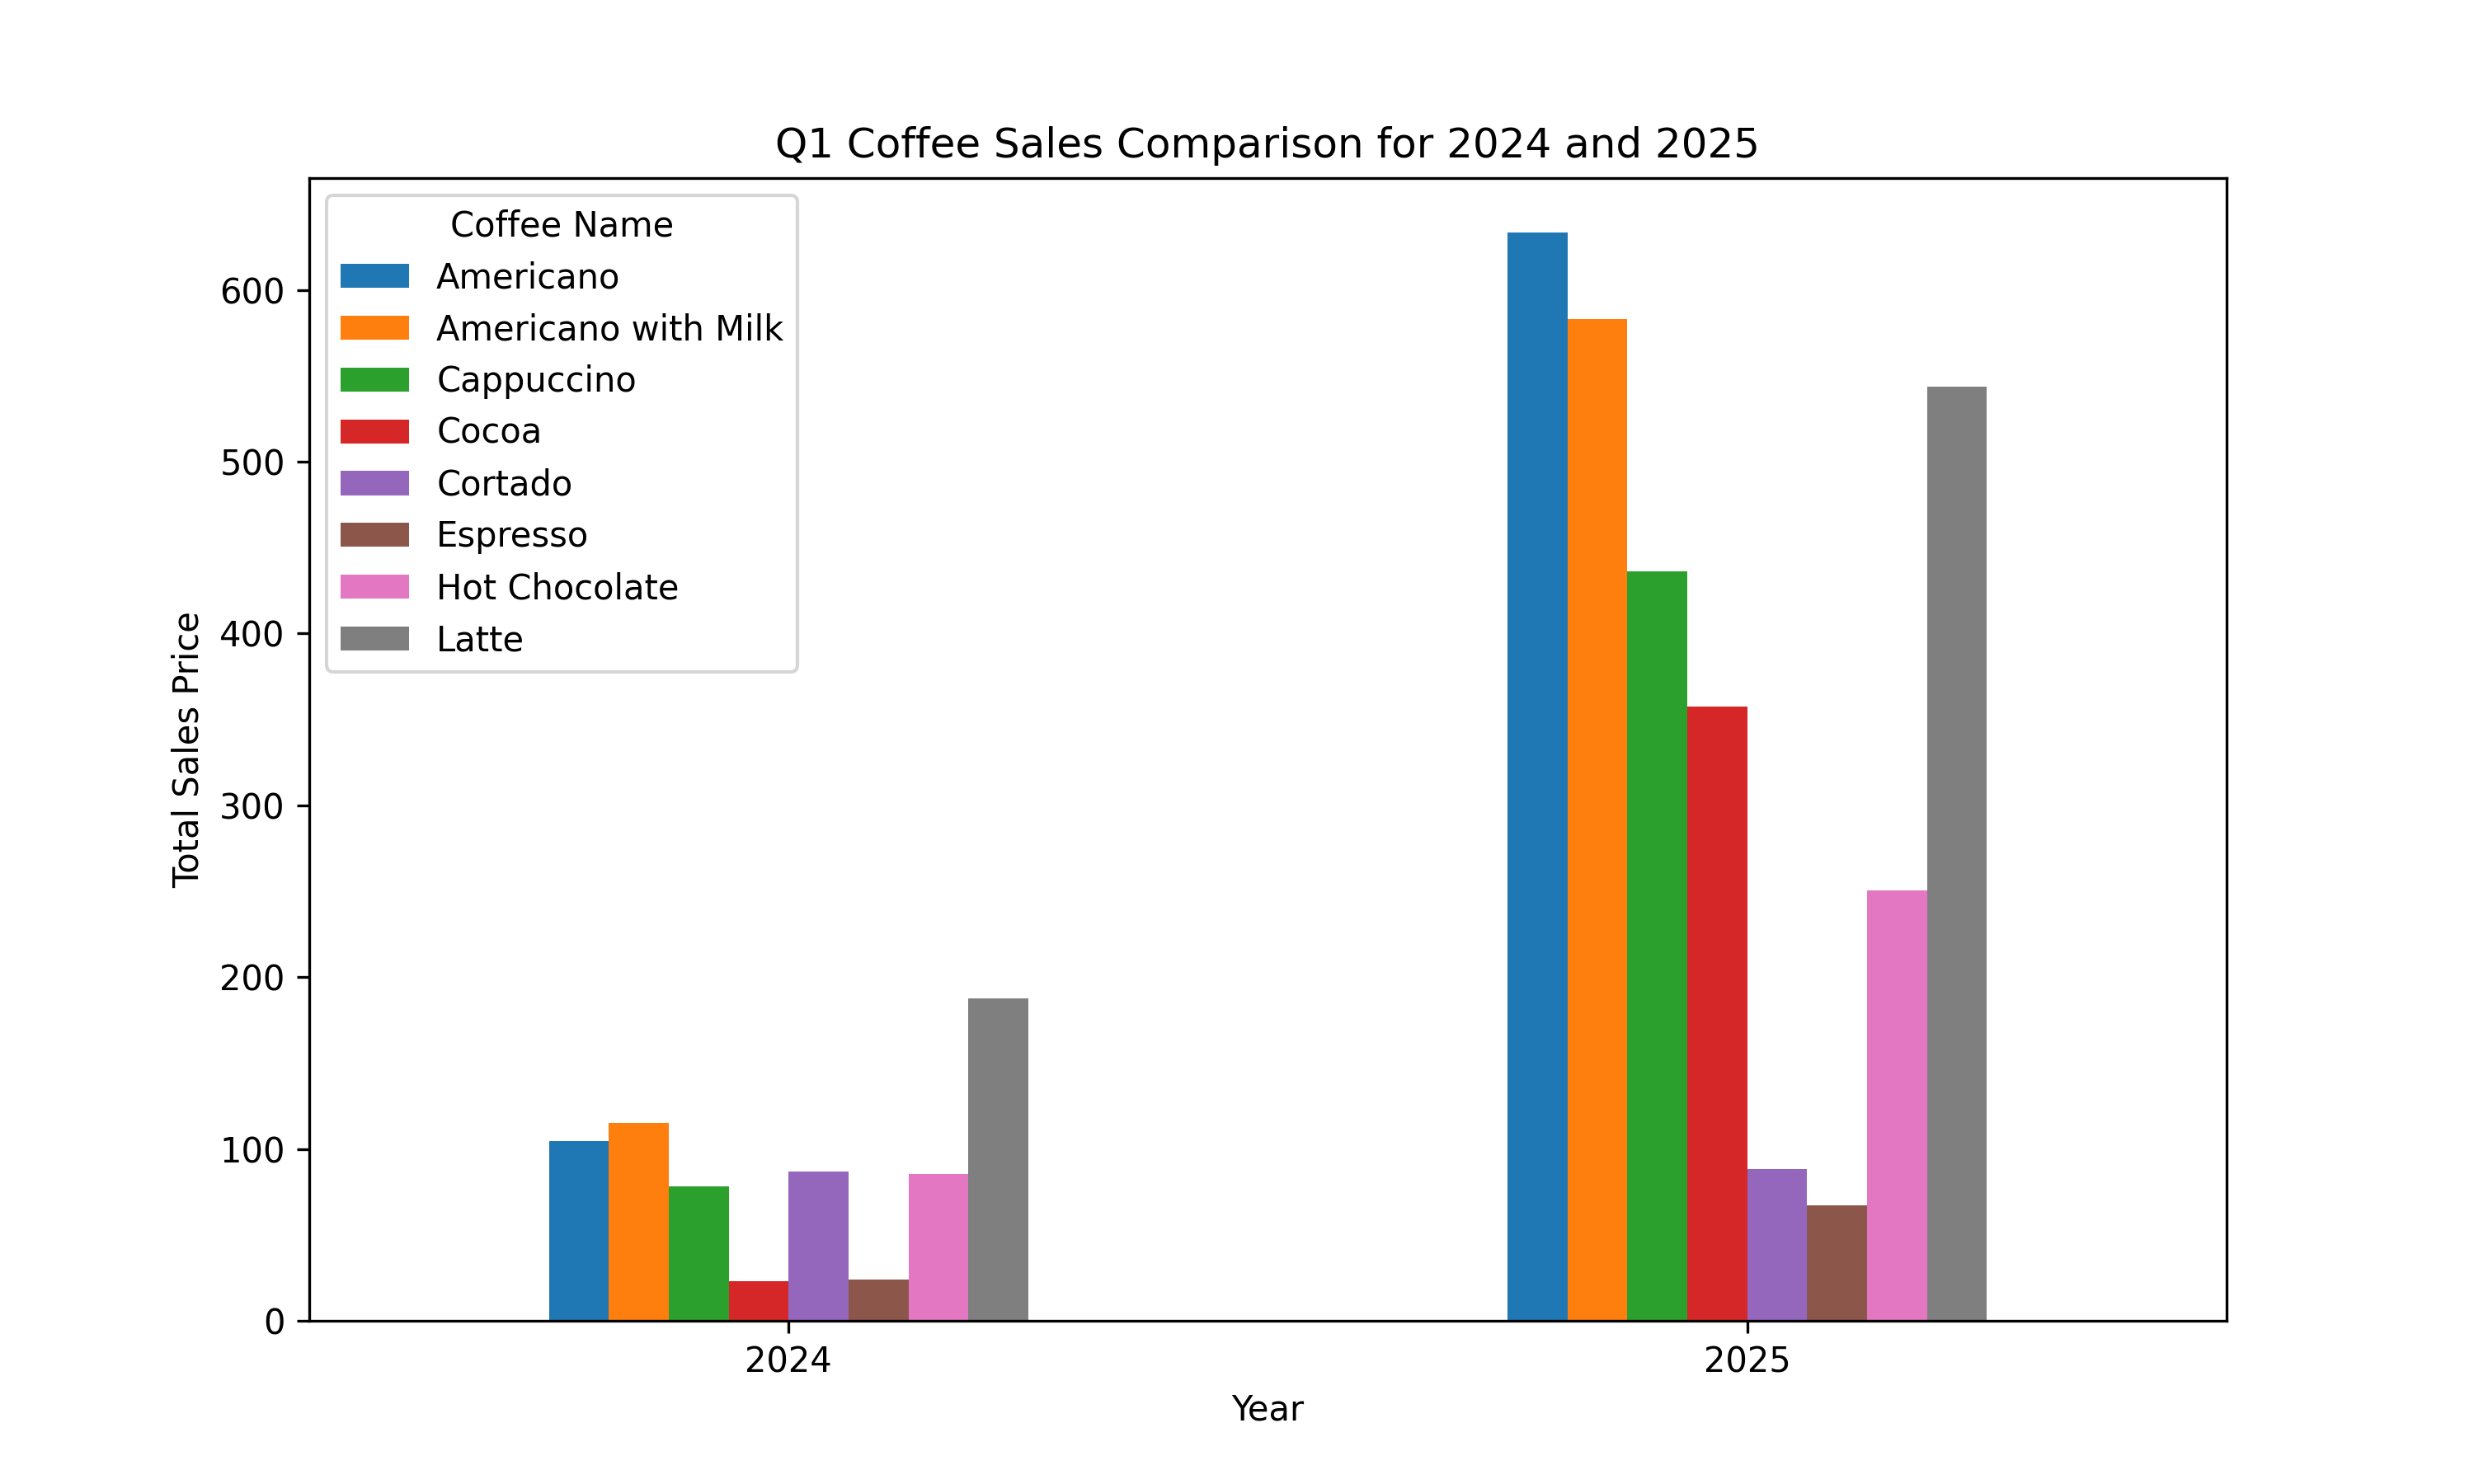


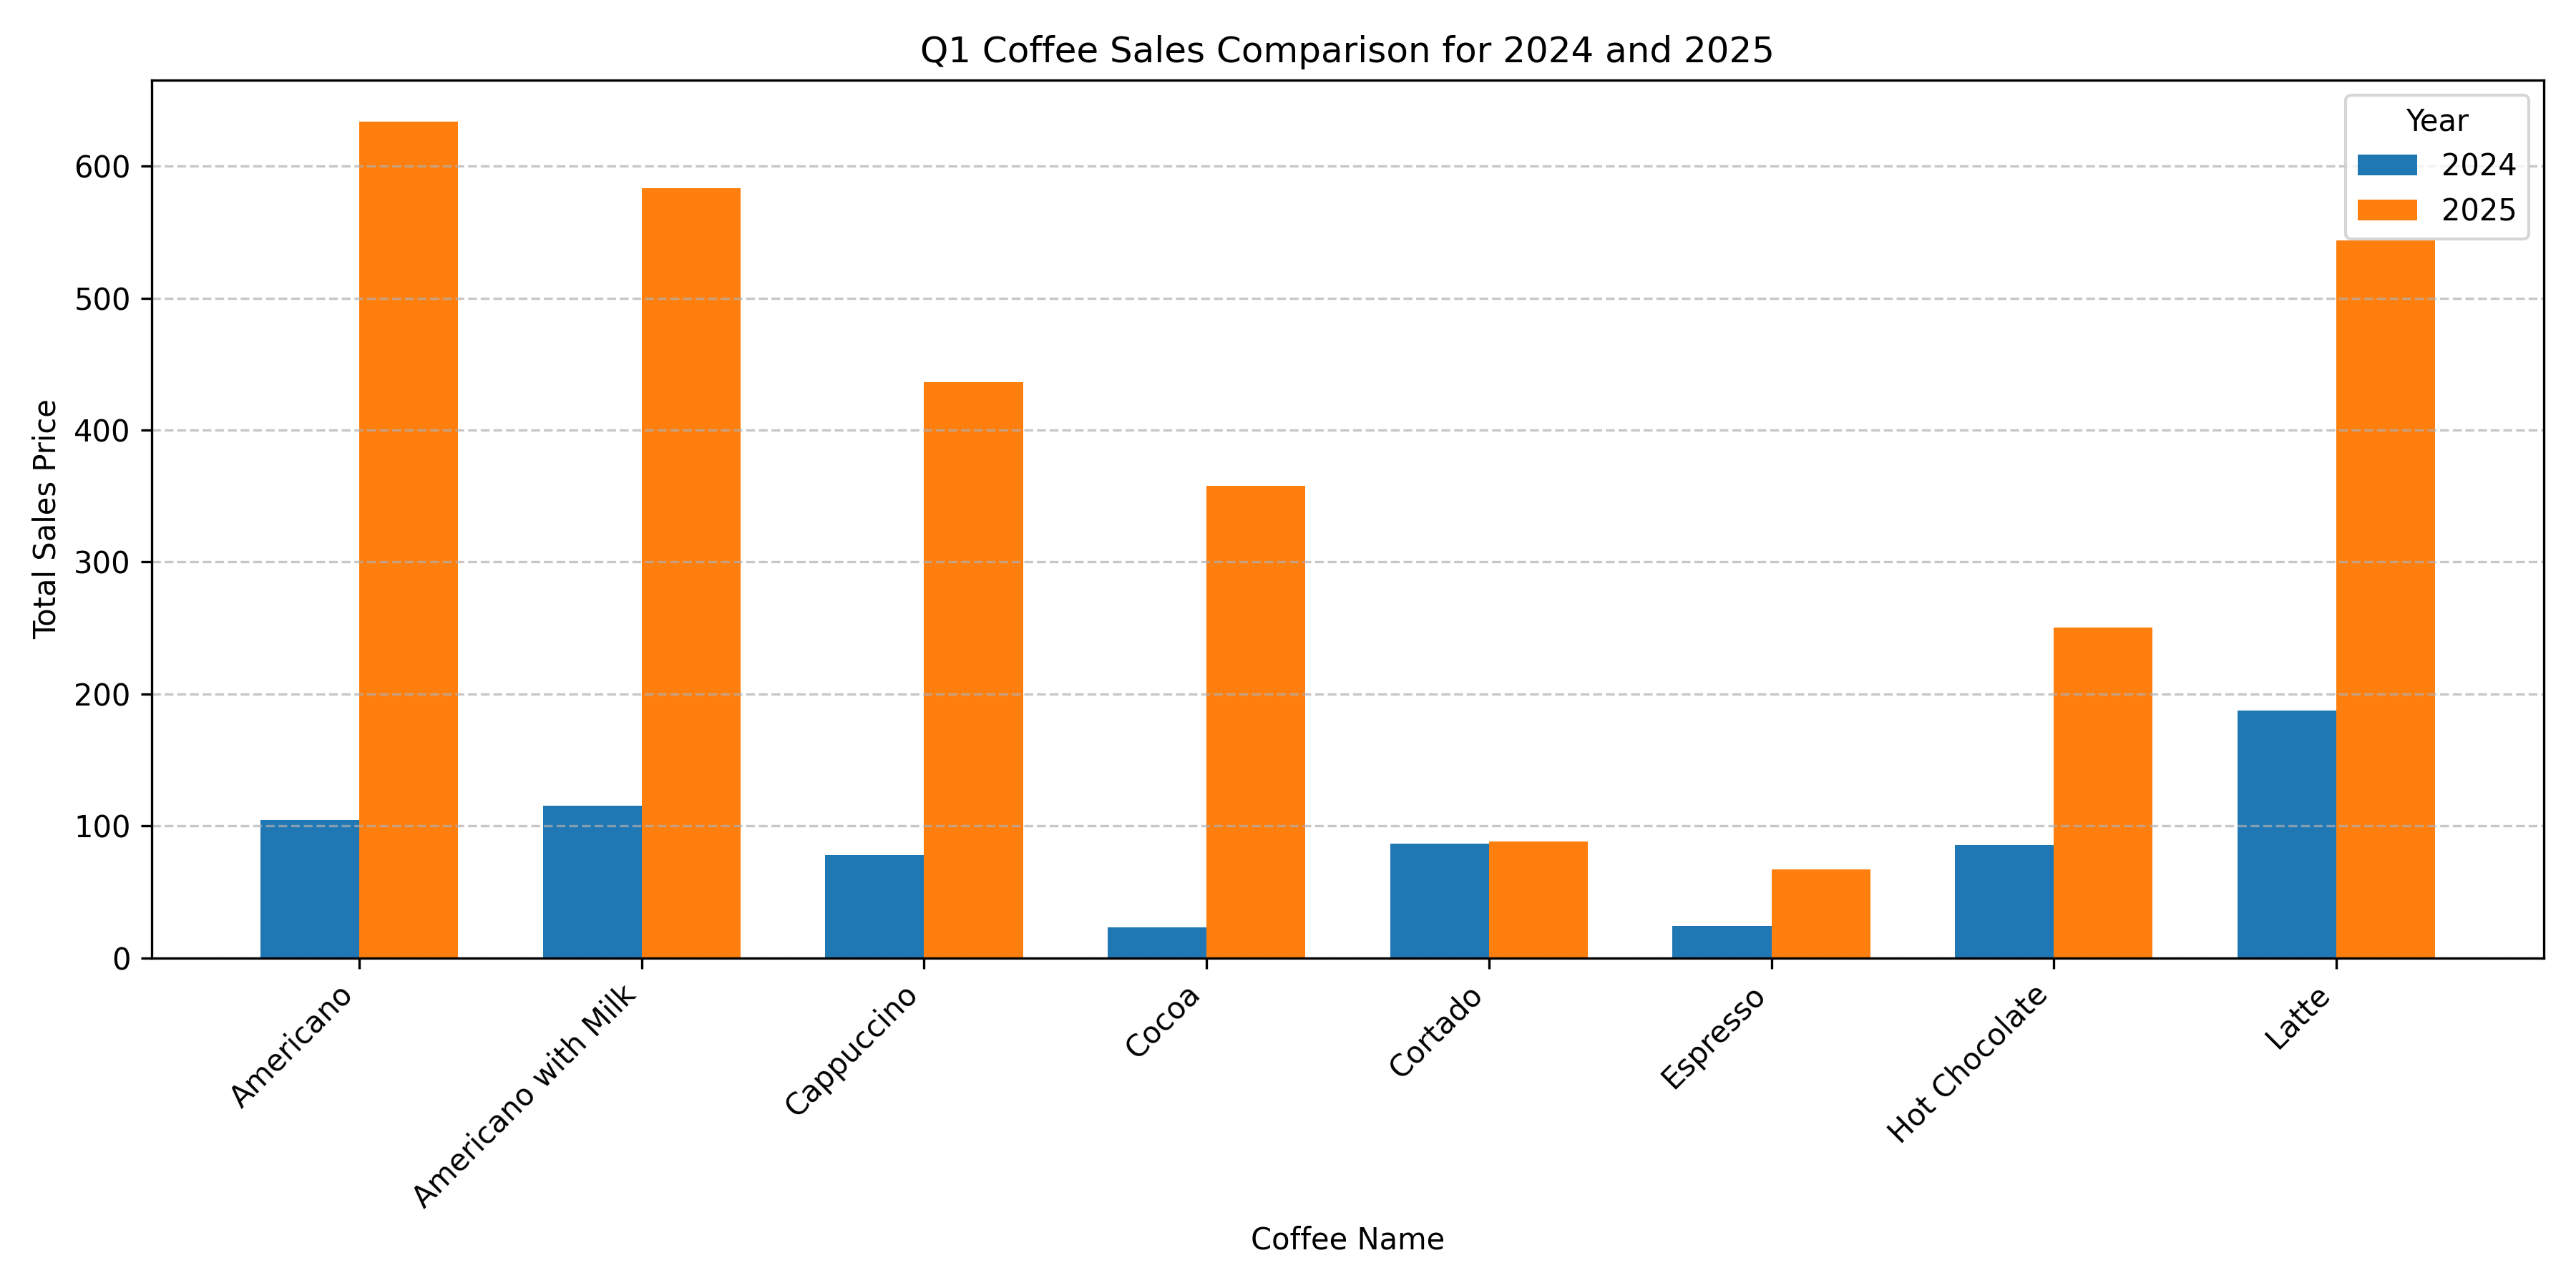

In [11]:
# Here, insert your updates
user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv."
generation_model="gpt-4.1-mini"
reflection_model="o4-mini"
image_basename="drink_sales"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)

_ = combine_charts_side_by_side(
    img_path1=f"{image_basename}_001_v1.png",
    img_path2=f"{image_basename}_001_v2.png",
    output_path=f"{image_basename}_side_by_side_001.jpg"
)

<img src="drink_sales_side_by_side_001.jpg" >

### Modify Prompt - more verbose


date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-05-26,14:11,card,ANON-0000-0000-0220,3.772,Hot Chocolate,2,5,2024
2024-09-22,08:02,card,ANON-0000-0000-0650,2.302,Cortado,3,9,2024
2024-08-10,16:57,card,ANON-0000-0000-0442,3.282,Cocoa,3,8,2024
2025-02-24,09:15,card,ANON-0000-0000-1191,3.576,Latte,1,2,2025
2024-12-16,09:53,card,ANON-0000-0000-0714,3.576,Cocoa,4,12,2024



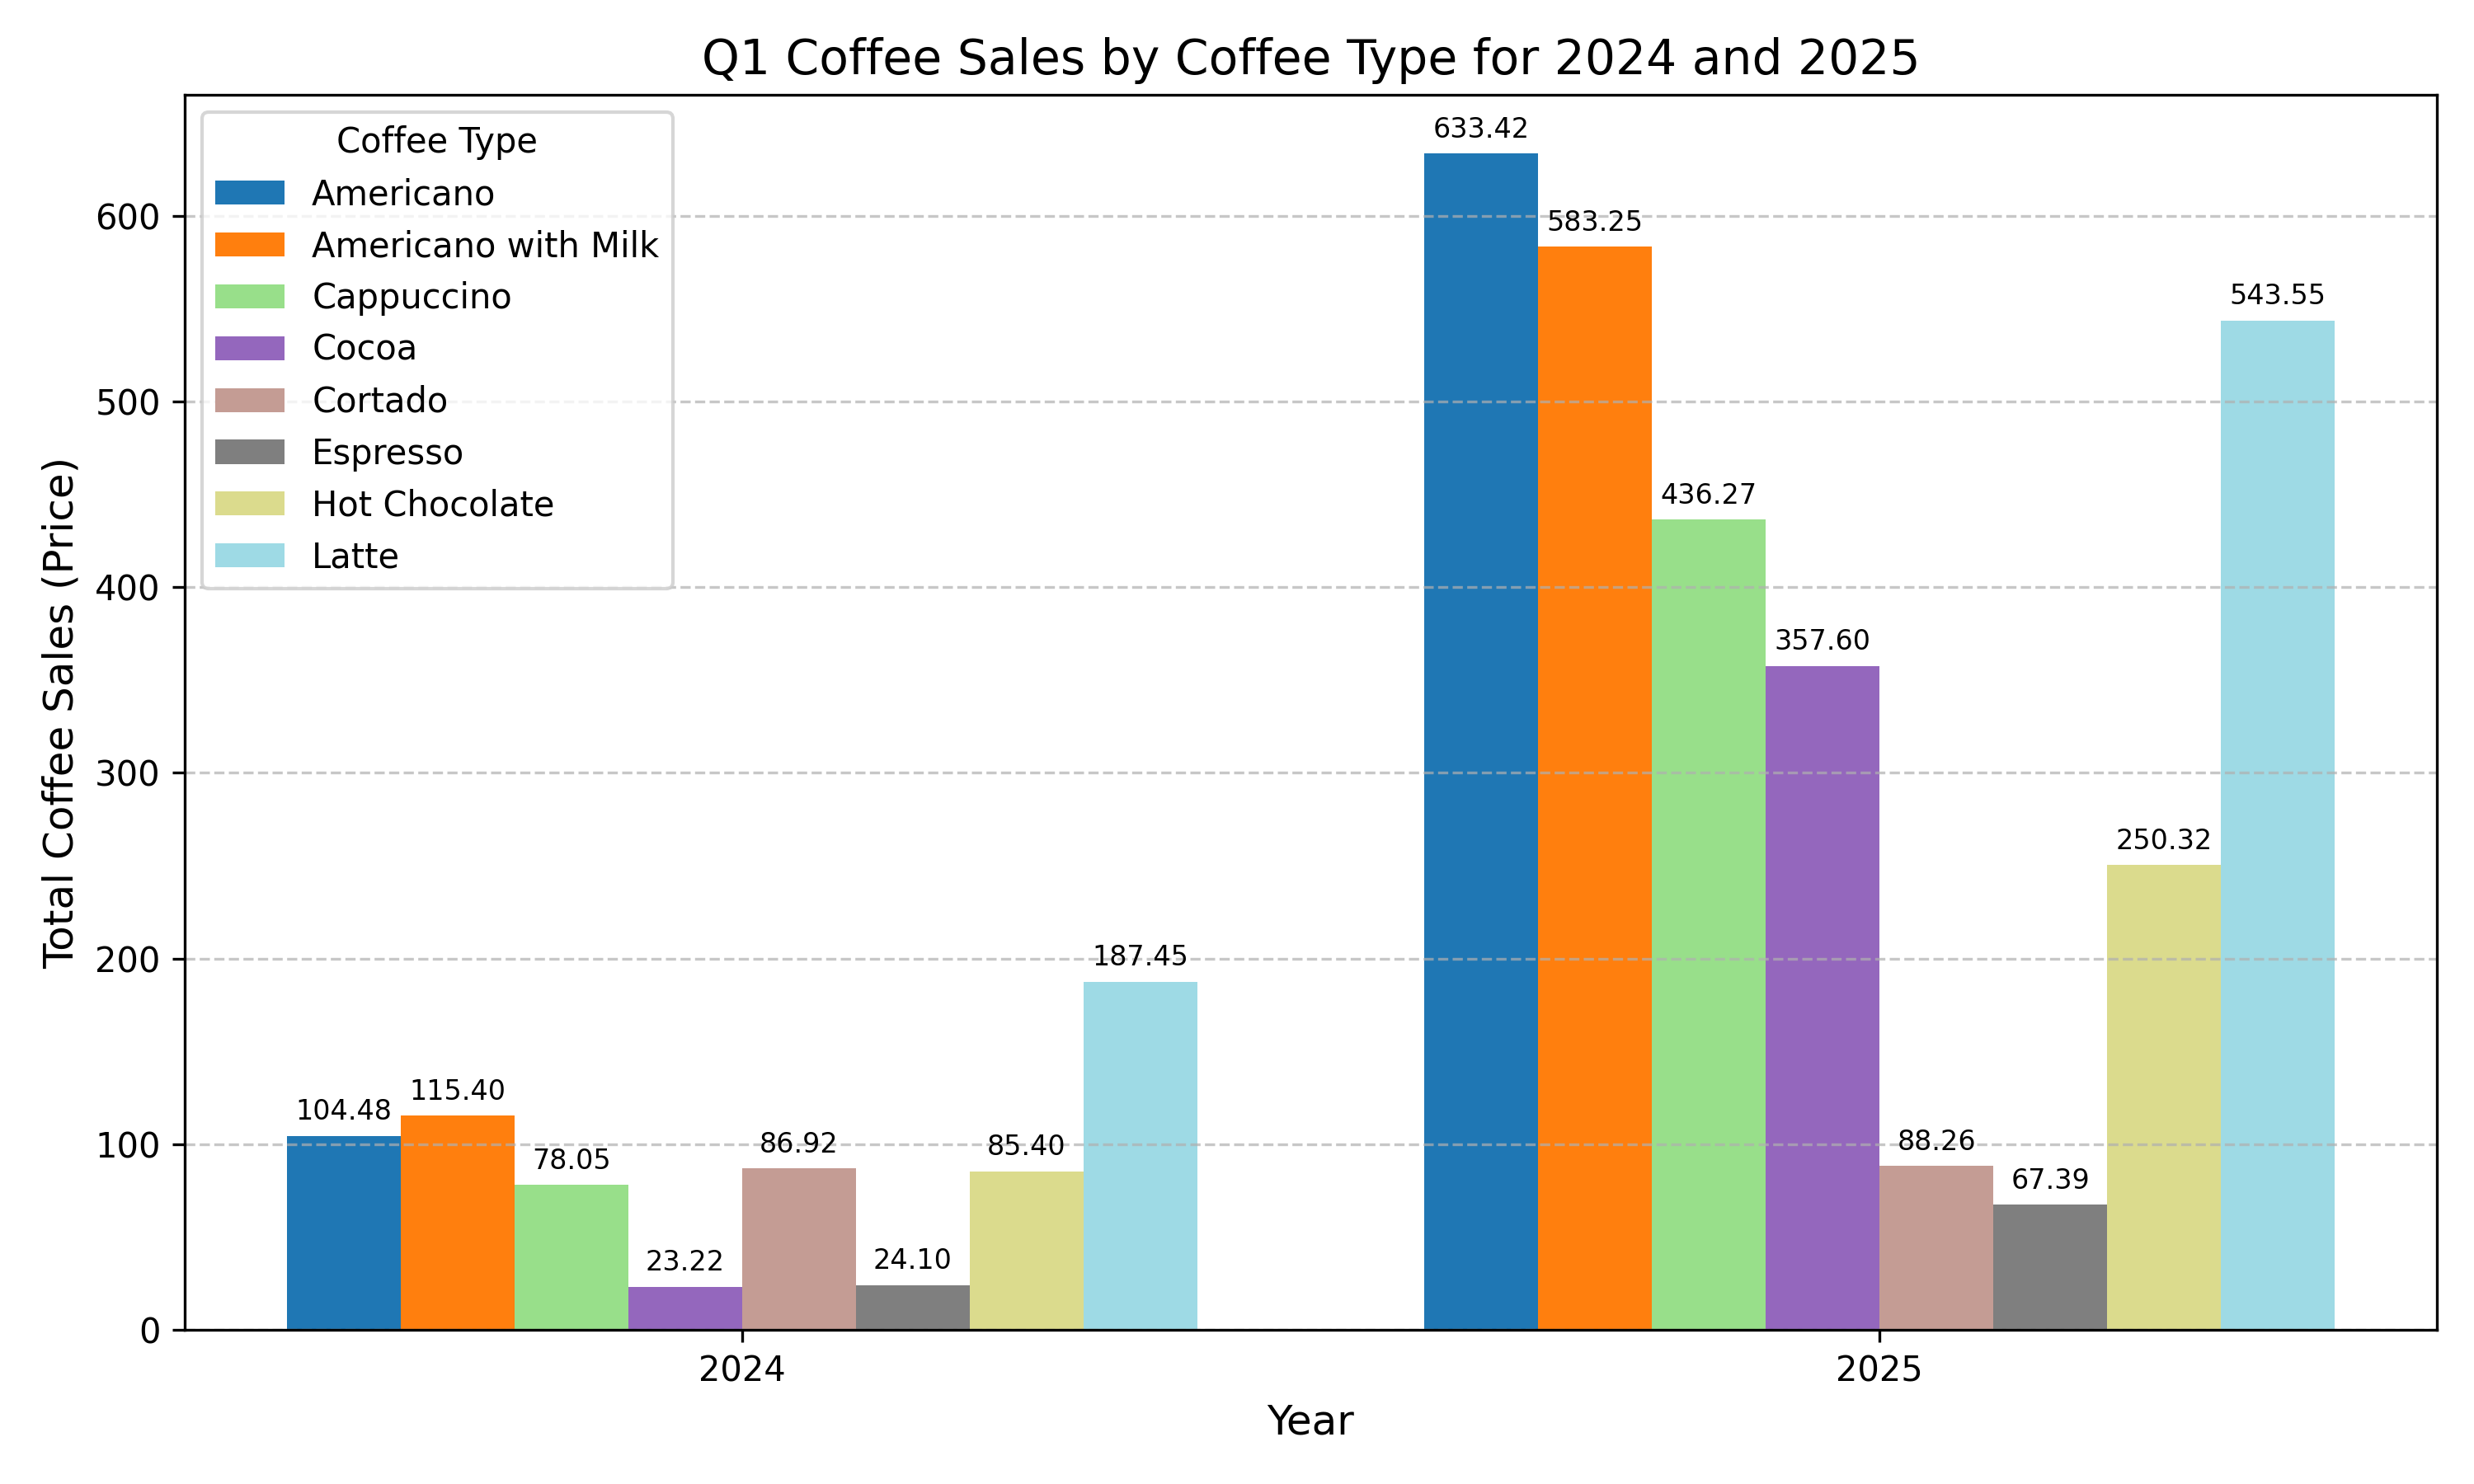


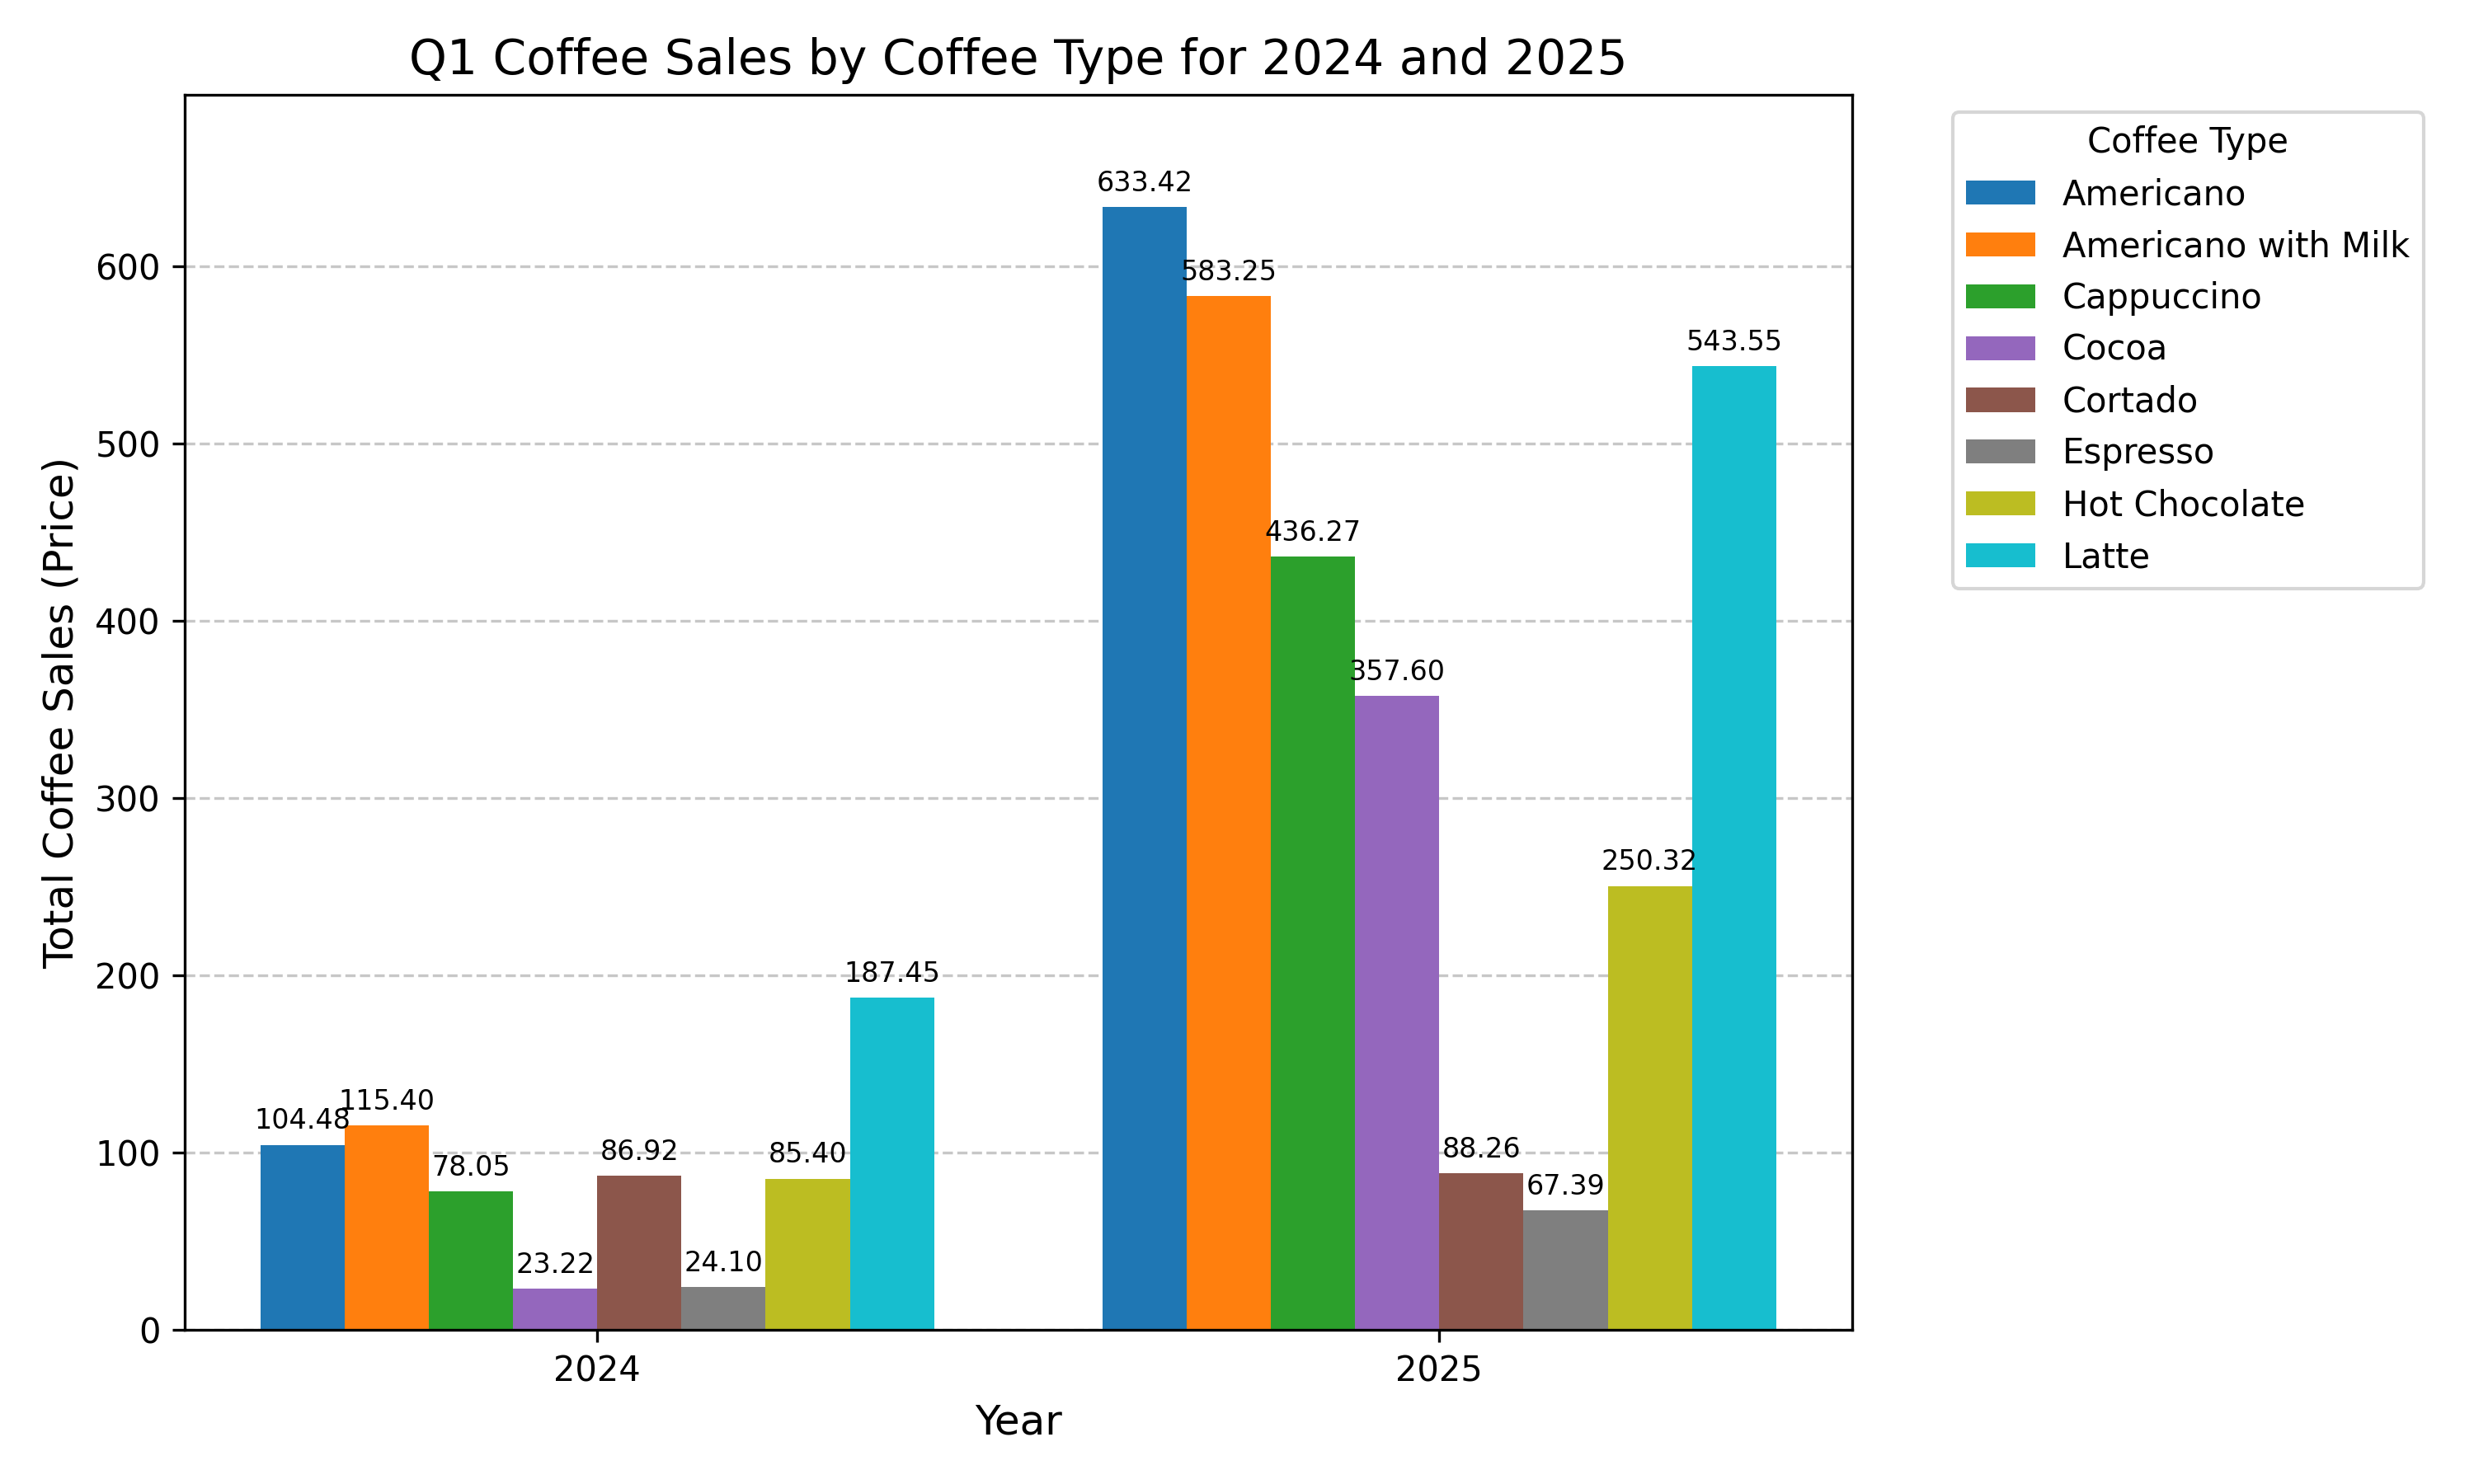

In [12]:
# Here, insert your updates
user_instructions=f"""Using the data in coffee_sales.csv, create a grouped bar chart comparing Q1 (January–March) coffee sales by coffee type for the years 2024 and 2025. 
Use the year as the x-axis, with multiple bars per year representing different coffee types. 
Assign a distinct color to each coffee type and include a single shared legend identifying them. 
Ensure both groups are visually aligned for easy comparison. 
Include clear axis labels, a descriptive title, and readable tick labels. 
Handle missing or inconsistent data gracefully. 
Add actual sales values on top of each bar for clarity.
Return complete Python code using matplotlib to generate and display the chart.
"""
generation_model="gpt-4.1-mini"
reflection_model="o4-mini"
image_basename="drink_sales"
run_number = "002"
# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename,
    run_number=run_number
)

_ = combine_charts_side_by_side(
    img_path1=f"{image_basename}_002_v1.png",
    img_path2=f"{image_basename}_002_v2.png",
    output_path=f"{image_basename}_side_by_side_002.jpg"
)

<img src="drink_sales_side_by_side_002.jpg" >